<a href="https://colab.research.google.com/github/mrymsadeghi/Colab_notebooks/blob/main/Embeddings_Img_similarity_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image

## Preparing the dataset

In [ ]:
! pip install -q kaggle

In [ ]:
%cd /content/drive/MyDrive/DL_projects_colab/Image_Similarity

/content/drive/MyDrive/DL_projects_colab/Image_Similarity


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"whitelineshine","key":"35eda443ae04a8d80220ef6ca6fc2970"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d arjunbasandrai/25-indian-bird-species-with-226k-images

100% 4.07G/4.07G [00:35<00:00, 149MB/s]
100% 4.07G/4.07G [00:35<00:00, 125MB/s]


In [ ]:
! mkdir dataset
! unzip 25-indian-bird-species-with-226k-images.zip -d dataset

## Exploring the data

In [ ]:
class_names = ['Asian Green Bee-Eater', 'Brown-Headed Barbet', 'Cattle Egret', 'Common Kingfisher', 'Common Myna', 'Common Rosefinch', 'Common Tailorbird', 'Coppersmith Barbet', 'Forest Wagtail', 'Gray Wagtail', 'Hoopoe', 'House Crow', 'Indian Grey Hornbill', 'Indian Peacock', 'Indian Pitta', 'Indian Roller', 'Jungle Babbler', 'Northern Lapwing', 'Red-Wattled Lapwing', 'Ruddy Shelduck', 'Rufous Treepie', 'Sarus Crane', 'White Wagtail', 'White-Breasted Kingfisher', 'White-Breasted Waterhen']

In [ ]:
dataset_path = "dataset/training_set"
class_dict = {}
for path, subdirs, files in os.walk(dataset_path):
  if files:
    class_dict[path.split("/")[-1]]=len(files)
print(class_dict)

{'Asian Green Bee-Eater': 924, 'Brown-Headed Barbet': 924, 'Cattle Egret': 918, 'Common Kingfisher': 868, 'Common Myna': 926, 'Common Rosefinch': 919, 'Common Tailorbird': 918, 'Coppersmith Barbet': 778, 'Forest Wagtail': 883, 'Gray Wagtail': 926, 'Hoopoe': 924, 'House Crow': 924, 'Indian Grey Hornbill': 922, 'Indian Peacock': 919, 'Indian Pitta': 629, 'Indian Roller': 926, 'Jungle Babbler': 930, 'Northern Lapwing': 930, 'Red-Wattled Lapwing': 930, 'Ruddy Shelduck': 925, 'Rufous Treepie': 860, 'Sarus Crane': 930, 'White Wagtail': 930, 'White-Breasted Kingfisher': 930, 'White-Breasted Waterhen': 930}


In [ ]:
dataset_path = "dataset/training_set"
classes = []
random_pics = []
for path, subdirs, files in os.walk(dataset_path):
  birdname = path.split("/")[-1]
  class_dict[birdname]=len(files)
  random_number = random.randint(0, len(files))
  classes.append(birdname)
  if files:
    img_path = os.path.join(path, files[random_number])
    random_pics.append(img_path)

In [ ]:
img_path

'dataset/training_set/White-Breasted Waterhen/ML315698811.jpg'

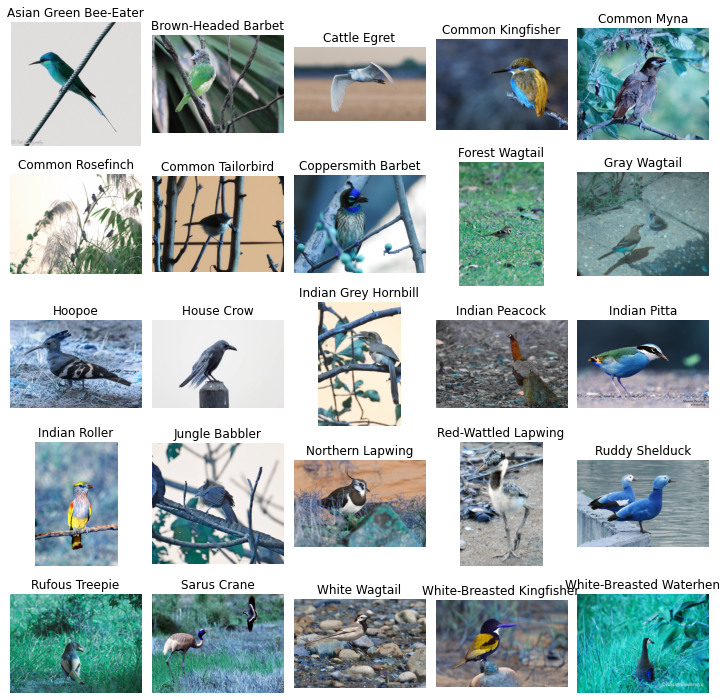

In [ ]:
birdsname_iterator = iter(class_dict)
picspath_iterator = iter(random_pics)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10))

for i in range(5):
    for j in range(5):
      bird_img = cv.imread(next(picspath_iterator))
      ax[i,j].imshow(bird_img) 
      ax[i,j].set_title(next(birdsname_iterator)) 
      ax[i,j].axis('off')
plt.tight_layout() 
plt.show()

In [ ]:
! unzip dataset/training_set_mini.zip -d dataset

In [ ]:
! unzip dataset/test_set_mini.zip -d dataset

In [ ]:
dataset_path = "dataset/training_set_mini"
class_dict = {}
for path, subdirs, files in os.walk(dataset_path):
  if files:
    class_dict[path.split("/")[-1]]=len(files)
print(class_dict)

{'Cattle Egret': 96, 'Common Kingfisher': 104, 'Common Rosefinch': 104, 'Coppersmith Barbet': 120, 'Gray Wagtail': 112, 'Hoopoe': 104}


##Cuda stuff

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
torch.cuda.is_available()

True

## Preparing the data

## Method 1 
### Get feature vector of images with pretrained ResNet Model
### Cosine similarity metric

In [ ]:
# create dataloader with required transforms 
tc = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()              
    ])

image_datasets = datasets.ImageFolder(dataset_path, transform=tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False)

print(len(image_datasets)) 

528


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

NameError: ignored

In [ ]:
def copy_embeddings(m, i, o):
    """Copy embeddings from the penultimate layer.
    """
    o = o[:, :, 0, 0].detach().numpy().tolist()
    outputs.append(o)

outputs = []
# attach hook to the penulimate layer
_ = layer.register_forward_hook(copy_embeddings)

In [ ]:
# Generate image's embeddings for all images in dloader and saves 
for X, y in dloader:
    _ = model(X)
print(len(outputs)) 

53


In [ ]:
# flatten list of embeddings to remove batches
list_embeddings = [item for sublist in outputs for item in sublist]

print(len(list_embeddings)) 
print(np.array(list_embeddings[0]).shape)

528
(512,)


In [ ]:
embedd1 = torch.tensor(list_embeddings[1])
embedd2 = torch.tensor(list_embeddings[2])


In [ ]:
input1 = torch.randn(100, 128)
input1

tensor([[ 1.1683,  0.4604, -2.5419,  ..., -0.5523, -0.1448, -1.0952],
        [ 1.5934,  1.7467,  0.7797,  ...,  0.6819,  0.3436, -0.9467],
        [ 0.3437, -0.3887,  0.5905,  ...,  0.2479, -0.6688,  0.3160],
        ...,
        [-2.7348, -0.9323,  0.3097,  ..., -0.5560,  1.0512,  1.4266],
        [ 0.4132, -0.4690,  2.2203,  ...,  1.3562, -0.6852, -0.2329],
        [ 1.2207, -1.1799, -0.7483,  ..., -0.2177, -0.4640,  0.4243]])

In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(embedd1.unsqueeze(0), embedd2.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.6460])



In [ ]:
for batch in tqdm(dloader, desc='Running the model inference'):
    images = batch['image'].to(device)
    labels += batch['label']
    image_paths += batch['image_path']
 
    output = model.forward(images)
 
    current_outputs = output.cpu().numpy()
    features = np.concatenate((outputs, current_outputs))

TypeError: ignored

## Method 2
### Using pretrained Resnet 18 to extract embeddings
### Visualize using Tensorboard

In [ ]:
import os
import re
import csv
from PIL import Image
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms

def get_vector(input_image):
    image = input_image.convert("RGB")  # in case input image is not in RGB format
    img_t = transform(image)
    batch_t = torch.unsqueeze(img_t, 0)
    my_embedding = torch.zeros([1, 512, 1, 1])
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    h = layer.register_forward_hook(copy_data)
    model(batch_t)
    h.remove()
    return my_embedding.squeeze().cpu().numpy()

model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
im_path = dataset_path
im_names = [os.path.join(root, name)
            for root, dirs, files in os.walk(im_path)
            for name in files
            if name.endswith(".jpg")]



In [ ]:
len(im_names)

528

In [ ]:
existing_images_df = pd.DataFrame([[im_name.split("/")[2], im_name.split("/")[3].split(".")[0]] for im_name in im_names],
                                  columns=['cat_id', 'pid'])
existing_images_df['impath'] = im_names
vecs = [list(get_vector(Image.open(impath))) for _, pid, impath in existing_images_df.values]
with open('vis/feature_vecs.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(vecs)

In [ ]:
labels = [imgname.split("/")[-2] for imgname in im_names]

In [ ]:
im_names

In [ ]:
# Create a sprite image.
images = [Image.open(filename).resize((300,300)) for filename in existing_images_df['impath']]
image_width, image_height = images[0].size
one_square_size = int(np.ceil(np.sqrt(len(images))))
master_width = (image_width * one_square_size) 
master_height = image_height * one_square_size
spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0))  # fully transparent
for count, image in enumerate(images):
    div, mod = divmod(count,one_square_size)
    h_loc = image_width*div
    w_loc = image_width*mod    
    spriteimage.paste(image,(w_loc,h_loc))
spriteimage.convert("RGB").save('sprite.jpg', transparency=0)

In [ ]:
metadata = existing_images_df[['cat_id', 'pid']].to_csv('vis/metadata.tsv', sep='\t', index=False)

In [ ]:
# embeddings {
#   tensor_path: "feature_vecs.tsv"
#   metadata_path: "metadata.tsv"
#   sprite {
#     image_path: "sprite.jpg"
#     single_image_dim: 50
#     single_image_dim: 50
#   }
# }

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir ./vis --port=6009
#--load_fast=false

In [ ]:
# Go to http://localhost:6006/#projector , press F5 to update the content an review your cloud of images.
# https://hanna-shares.medium.com/how-to-visualize-image-feature-vectors-1e309d45f28f
# https://medium.com/gsi-technology/visualising-embeddings-using-t-sne-8fd4e31b56e2
# https://www.gsitechnology.com/Visualizing-Embeddings-Using-t-SNE

In [ ]:
# https://towardsdatascience.com/introduction-to-embedding-clustering-and-similarity-11dd80b00061

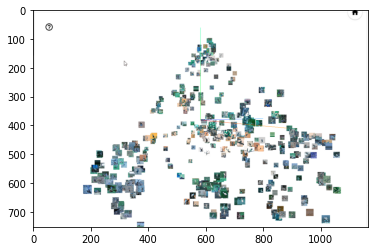

In [ ]:
img1 = cv.imread("/content/drive/MyDrive/DL_projects_colab/Image_Similarity/2023-03-14 15_43_32-Downloads.png")
plt.imshow(img1)

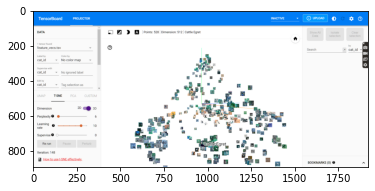

In [ ]:
img1 = cv.imread("/content/drive/MyDrive/DL_projects_colab/Image_Similarity/2023-03-14 15_43_39-Downloads.png")
plt.imshow(img1)

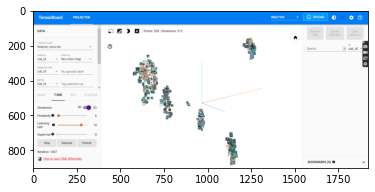

In [ ]:
img1 = cv.imread("/content/drive/MyDrive/DL_projects_colab/Image_Similarity/2023-03-14 15_45_03-Downloads.png")
plt.imshow(img1)

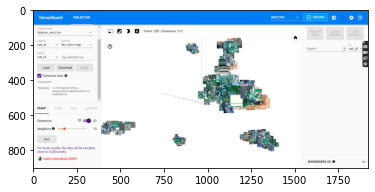

In [ ]:
img1 = cv.imread("/content/drive/MyDrive/DL_projects_colab/Image_Similarity/2023-03-14 15_47_01-Downloads.png")
plt.imshow(img1)

In [ ]:
import tqdm

In [ ]:
from sklearn.manifold import TSNE


In [ ]:
tsne = TSNE(n_components=2).fit_transform(vecs)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
set(labels)

{'Cattle Egret',
 'Common Kingfisher',
 'Common Rosefinch',
 'Coppersmith Barbet',
 'Gray Wagtail',
 'Hoopoe'}

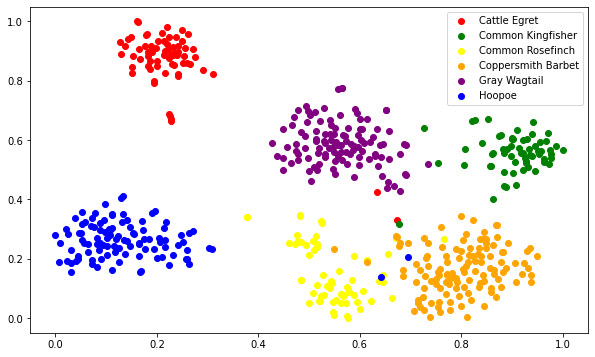

In [ ]:
# initialize a matplotlib plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

colors_per_class = {'Cattle Egret':'red', 'Common Kingfisher':'green', 'Common Rosefinch':'yellow', 'Coppersmith Barbet':'orange', 'Gray Wagtail':'purple', 'Hoopoe':'blue'}
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors_per_class[label]
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()

# Training
## Fine tuned ResNet model on FineTune_Resnet_PyTorch.ipynb

In [ ]:
# Fine tuned model on FineTune_Resnet_PyTorch.ipynb

# Get features from the new model

In [ ]:
import os
import re
import csv
from PIL import Image
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms

def get_vector(input_image):
    image = input_image.convert("RGB")  # in case input image is not in RGB format
    img_t = transform(image)
    batch_t = torch.unsqueeze(img_t, 0)
    my_embedding = torch.zeros([1, 512, 1, 1])
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    h = layer.register_forward_hook(copy_data)
    model(batch_t)
    h.remove()
    return my_embedding.squeeze().cpu().numpy()

In [ ]:
model = torch.load("/content/drive/MyDrive/DL_projects_colab/Image_Similarity/dataset/models/resnet18_birds.pt")
layer = model._modules.get('avgpool')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [ ]:
im_path = "/content/drive/MyDrive/DL_projects_colab/Image_Similarity/dataset/train"
im_names = [os.path.join(root, name)
            for root, dirs, files in os.walk(im_path)
            for name in files
            if name.endswith(".jpg")]
len(im_names)

528

In [ ]:
existing_images_df = pd.DataFrame([[im_name.split("/")[2], im_name.split("/")[3].split(".")[0]] for im_name in im_names],
                                  columns=['cat_id', 'pid'])
existing_images_df['impath'] = im_names
vecs = [list(get_vector(Image.open(impath))) for _, pid, impath in existing_images_df.values]
with open('vis/feature_vecs.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(vecs)

In [ ]:
tsne = TSNE(n_components=2).fit_transform(vecs)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

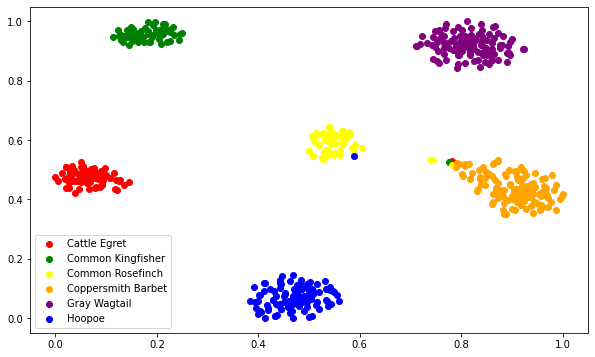

In [ ]:
# initialize a matplotlib plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

colors_per_class = {'Cattle Egret':'red', 'Common Kingfisher':'green', 'Common Rosefinch':'yellow', 'Coppersmith Barbet':'orange', 'Gray Wagtail':'purple', 'Hoopoe':'blue'}
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors_per_class[label]
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()